In [188]:
# importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image, ImageFile
import os
import glob
from tqdm import tqdm

# modeling and neural network libs
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix, plot_confusion_matrix


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [36]:
train_path = 'chest_xray/train/'
test_path = 'chest_xray/test/'

In [37]:
train_neg_filepath = 'chest_xray/train/NORMAL/'
train_pos_filepath = 'chest_xray/train/PNEUMONIA/'
test_neg_filepath = 'chest_xray/test/NORMAL/'
test_pos_filepath = 'chest_xray/test/PNEUMONIA/'

In [38]:
files_train_neg = glob.glob(os.path.join(train_neg_filepath,'*.jpeg'))
files_train_pos = glob.glob(os.path.join(train_pos_filepath,'*.jpeg'))
files_test_neg = glob.glob(os.path.join(test_neg_filepath,'*.jpeg'))
files_test_pos = glob.glob(os.path.join(test_pos_filepath,'*.jpeg'))

In [116]:
def img_to_array_list(filepath):
    arr_list = []
    for img in tqdm(filepath):
        pic = Image.open(img)
        pic.load()
        arr_list.append(np.asarray(pic))
    return arr_list

In [117]:
train_neg = img_to_array_list(files_train_neg)
train_pos = img_to_array_list(files_train_pos)
test_neg = img_to_array_list(files_test_neg)
test_pos = img_to_array_list(files_test_pos)

100%|██████████| 390/390 [00:01<00:00, 286.18it/s]


In [130]:
train_neg

[array([[148, 150, 145, ..., 102, 104, 107],
        [147, 146, 145, ..., 102, 104, 106],
        [144, 145, 147, ..., 105, 107, 109],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8),
 array([[71, 75, 69, ..., 38, 37, 39],
        [74, 74, 69, ..., 38, 36, 37],
        [74, 75, 67, ..., 38, 36, 35],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[ 0, 43, 42, ...,  0,  0,  0],
        [ 0, 43, 41, ...,  0,  0,  0],
        [ 1, 43, 41, ...,  0,  0,  0],
        ...,
        [ 1, 43, 45, ...,  0,  0,  0],
        [ 1, 44, 45, ...,  0,  0,  0],
      

In [125]:
train_list = []
for img in train_neg:
    train_list.append((img, 0))
for img in train_pos:
    train_list.append((img, 1))
train_list = pd.DataFrame(train_list, columns=['img', 'target'])
train_list.head()

,img,target
0,"[[148, 150, 145, 149, 152, 148, 149, 144, 146,...",0
1,"[[71, 75, 69, 67, 65, 64, 66, 66, 68, 66, 64, ...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,"[[0, 43, 42, 38, 31, 24, 18, 13, 6, 3, 0, 0, 0...",0
4,"[[35, 35, 34, 34, 35, 35, 36, 40, 40, 37, 36, ...",0


In [131]:
train_list['img'][0]

array([[148, 150, 145, ..., 102, 104, 107],
       [147, 146, 145, ..., 102, 104, 106],
       [144, 145, 147, ..., 105, 107, 109],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [126]:
train_list['target'].value_counts()

1    3883
0    1348
Name: target, dtype: int64

In [177]:
X = train_list['img']
y = train_list['target']

In [181]:
X.shape

(5231,)

In [185]:
y.unique()

array([0, 1], dtype=int64)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42,
                                                    test_size=0.2)
X_train.shape

(4184,)

## Dummy Model

In [161]:
baseline_model = DummyClassifier(strategy='uniform')
baseline_model.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [162]:
dummy_acc = baseline_model.score(X_train, y_train)
dummy_acc

0.498565965583174

In [163]:
cross_val_score(baseline_model, X_train, y_train)

array([0.52210275, 0.51612903, 0.50179211, 0.49342891, 0.52631579])

In [164]:
dummy_preds = baseline_model.predict(X_train)

In [165]:
recall_score(y_train, dummy_preds)

0.5076775431861804

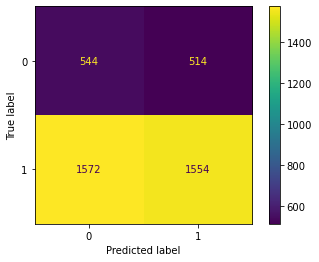

In [166]:
plot_confusion_matrix(baseline_model, X_train, y_train)

## Simple NN

In [ ]:
# 80/20 split
img_dgen = ImageDataGenerator(rescale=1./255, validation_split = 0.20)


#training dir
train_set = img_dgen.flow_from_directory(train_path, target_size=(64, 64), 
                                         color_mode='grayscale', class_mode='binary', subset='training')

validation_set = img_dgen.flow_from_directory(train_path, target_size=(64, 64), 
                                         color_mode='grayscale', class_mode='binary', subset='validation')

# testing dir
test_set = img_dgen.flow_from_directory(test_path, target_size=(64, 64), 
                                         color_mode='grayscale', class_mode='binary', shuffle=False)

In [190]:
model = Sequential()
model.add(Flatten(input_shape=(64,64,1)))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(train_set, epochs=50, batch_size=360)

Epoch 1/50
131/131 [==============================] - 22s 171ms/step - loss: 0.4341 - accuracy: 0.8086
Epoch 2/50
131/131 [==============================] - 23s 173ms/step - loss: 0.2839 - accuracy: 0.8827
Epoch 3/50
131/131 [==============================] - 22s 172ms/step - loss: 0.2307 - accuracy: 0.9066
Epoch 4/50
131/131 [==============================] - 23s 172ms/step - loss: 0.1982 - accuracy: 0.9226
Epoch 5/50
131/131 [==============================] - 22s 171ms/step - loss: 0.1870 - accuracy: 0.9290
Epoch 6/50
131/131 [==============================] - 22s 170ms/step - loss: 0.1743 - accuracy: 0.9298
Epoch 7/50
131/131 [==============================] - 22s 171ms/step - loss: 0.1666 - accuracy: 0.9324
Epoch 8/50
131/131 [==============================] - 22s 170ms/step - loss: 0.1622 - accuracy: 0.9329
Epoch 9/50
131/131 [==============================] - 22s 170ms/step - loss: 0.1541 - accuracy: 0.9410
Epoch 10/50
131/131 [==============================] - 22s 171ms/step - l